# Zillow:
<hr style="border:2px solid black">

## Goal/Ask: 
* Predict Property Tax assessed values ('taxcaluedollarcnt') of **Single Family Properties** that had a transaction during 2017. 
* Improve the performance of existing model
<hr style="border:2px solid black">


# Imports


In [60]:
# Standard ds imports:
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Data Prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


# Statistics
from scipy.stats import pearsonr, spearmanr, stats

# Modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE

# Model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Custom Moduls
import os
import env
import acquire as a
import prepare as p

<hr style="border:2px solid black">

# **Acquire**
Plan --> **Acquire** --> Prepare --> Explore --> Model --> Deliver




In [61]:
# Acquire
z = acquried_zillow = a.get_zillow_data()

<hr style="border:2px solid black">

# **Prepare**
Plan --> Acquire --> **Prepare** --> Explore --> Model --> Deliver


**Prepare Actions:**
* Clean:
    * Drop dupicates
    * Rename columns
    * Handle nulls: imputed column 'poolcnt' to account for the negative case
    * Correct dtypes
    * Handle outliers (drop top and bottom 0.5%)
* Preprocess:
    * Split into train, validate, test (60/20/20)
    * Scale data 
    * Split into x and y

In [62]:
# Clean
z = zillow_clean = p.prep_zillow(z)

In [63]:
# Preprocess
x_train, y_train, x_validate, y_validate, x_test, y_test, train_scaled, validate_scaled, test_scaled, train, validate, test = p.preprocess(z)

<hr style="border:2px solid black">

# **Explore**
Plan --> Acquire --> Prepare --> **Explore** --> Model --> Deliver

##### **Univariate Distribution: tax_value**

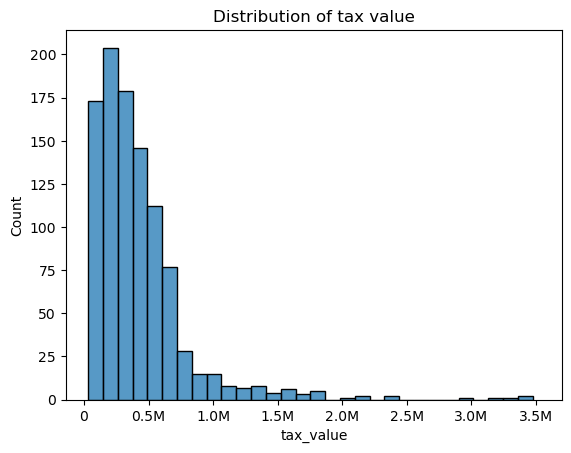

In [64]:
#### Show distribution of Target Variable 'tax_value'

# Create a countplot of tax_value for train data
ax = sns.histplot(data=z.sample(1000), x='tax_value', bins=30)

# Set the x-axis ticks in increments of 100,000
tick_values = range(0, int(z['tax_value'].max()) + 100000, 100000)
ax.set_xticks(tick_values)

# Format the tick labels to display values in millions
tick_labels = [f'{val/1000000:.1f}M' if val > 0 else '0' for val in tick_values]
ax.set_xticklabels(tick_labels)

# Set the major tick locator to display labels only every 500,000
ax.xaxis.set_major_locator(mticker.MultipleLocator(500000))

plt.ylabel('Count')
plt.xlabel('tax_value')
plt.title('Distribution of tax value')
plt.show()

##### **Univariate Distributions: independent variables**

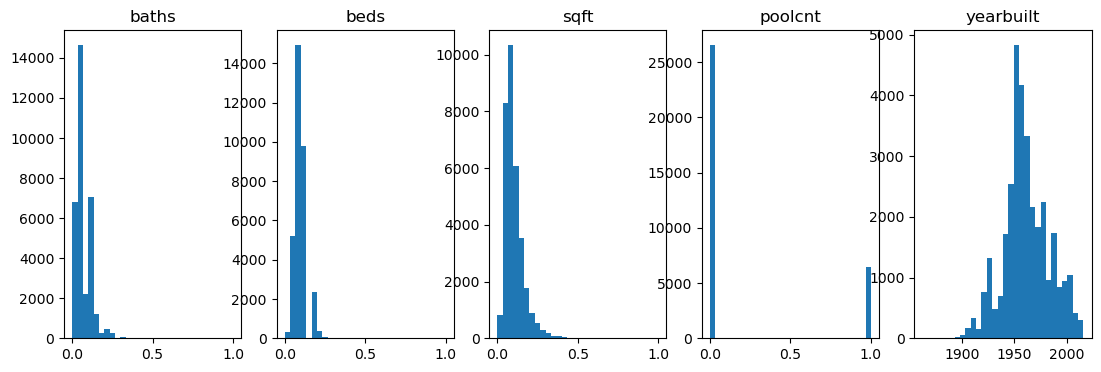

In [65]:
plt.figure(figsize=(16, 4))
# List of columns
cols = ['baths', 'beds', 'sqft','poolcnt','yearbuilt']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,6, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    train_scaled[col].hist(bins=30)

    # Hide gridlines.
    plt.grid(False)

> ## <u>Does the size of a house (sqft) correlate with Tax Value?</u>

<Figure size 1000x800 with 0 Axes>

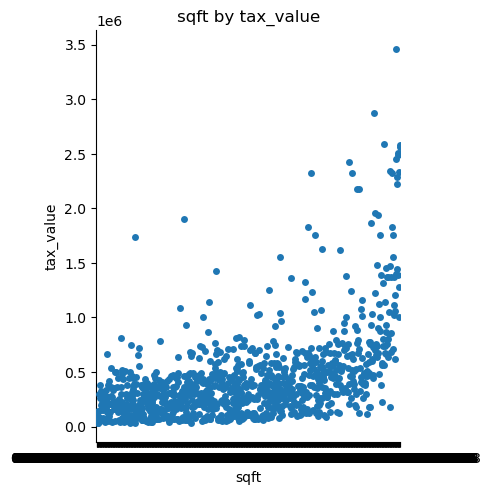

In [66]:
# Create swarm plot of sqft to tax_value
train_sample = train_scaled.sample(1000)
plt.figure(figsize=(10, 8))
sns.catplot(data=train_sample, x=train_sample.sqft, y=train_sample.tax_value, kind='swarm')
plt.title("sqft by tax_value")
plt.show()

In [67]:
print(f' Average finished sqft {zillow_clean.sqft.mean()}')

 Average finished sqft 1852.3152839062302


### Hypothesis

- ${H_0}$: There is no linear correlation between sqft and taxvalue
- ${H_a}$:  There is a linear correlation between sqft and taxvalue

In [68]:
# Set confidence level
alpha = 0.05

r, p = spearmanr(train_scaled.sqft, train_scaled.tax_value)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a linear relationship betwen sqft and taxvalue.')
else:
    print('We fail to reject the null hypothesis')
    
print(r,p)

We can reject our null hypothesis and suggest that there is a linear relationship betwen sqft and taxvalue.
0.5185489293344613 0.0


>## <u>Do the number of beds correlate with Tax Value?</u>

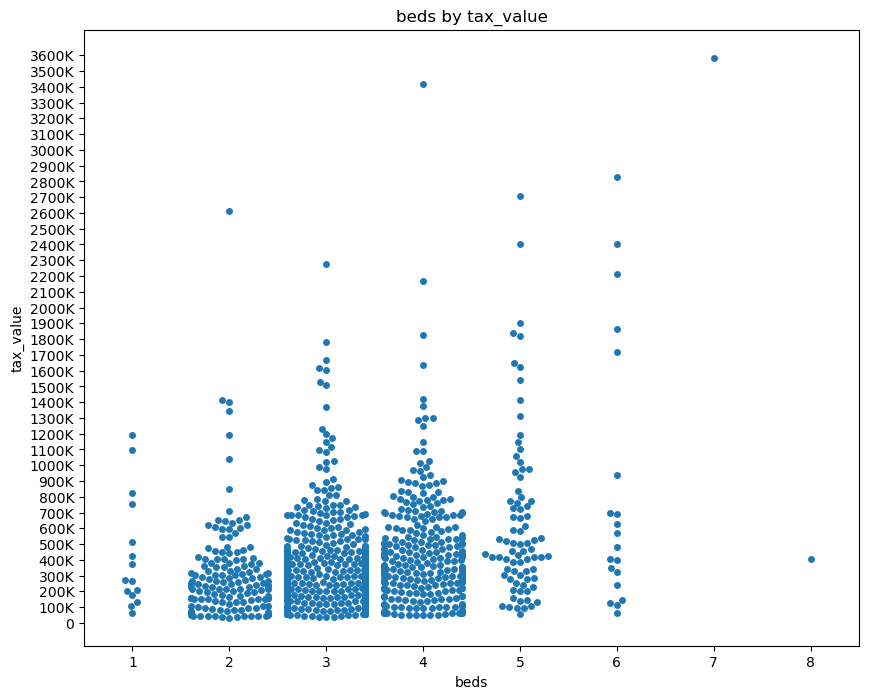

In [69]:
train_sample = zillow_clean.sample(1000)

# Create a swarm plot using Seaborn
plt.figure(figsize=(10, 8))
sns.swarmplot(data=train_sample, x='beds', y='tax_value')

# Customize the y-axis ticks and labels for tax_value
ax = plt.gca()  # Get the current Axes

# Set the y-axis ticks in increments of 100,000
tick_values = range(0, int(train_sample['tax_value'].max()) + 100000, 100000)
ax.set_yticks(tick_values)

# Format the y-axis tick labels to display values in hundreds of thousands
tick_labels = [f'{val/100000:.0f}00K' if val > 0 else '0' for val in tick_values]
ax.set_yticklabels(tick_labels)

plt.title("beds by tax_value")
plt.show()

In [70]:
print(f' 1 beds difference from mean value: {zillow_clean.tax_value[zillow_clean.beds == 1].mean() - zillow_clean.tax_value.mean()}')

print(f' 2 beds difference from mean value: {zillow_clean.tax_value[zillow_clean.beds == 2].mean() - zillow_clean.tax_value.mean()}')

print(f' 3 beds difference from mean value: {zillow_clean.tax_value[zillow_clean.beds == 3].mean() - zillow_clean.tax_value.mean()}')

print(f' 4 beds difference from mean value: {zillow_clean.tax_value[zillow_clean.beds == 4].mean() - zillow_clean.tax_value.mean()}')

print(f' Average number of beds {zillow_clean.beds.mean()}')

 1 beds difference from mean value: -151712.8494128753
 2 beds difference from mean value: -122175.58134630352
 3 beds difference from mean value: -62714.51886949607
 4 beds difference from mean value: 64350.35470486956
 Average number of beds 3.308492673094732


### Hypothesis

- ${H_0}$: There is no linear correlation between beds and taxvalue
- ${H_a}$:  There is a linear correlation between beds and taxvalue

In [71]:
r, p = spearmanr(train_scaled.beds, train_scaled.tax_value)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between beds and taxvalue.')
else:
    print('We fail to reject the null hypothesis')
    
print(r,p)

We can reject our null hypothesis and suggest that there is a relationship between beds and taxvalue.
0.2949030045274697 0.0


>## <u>Do the number of baths correlate with Tax Value?</u>

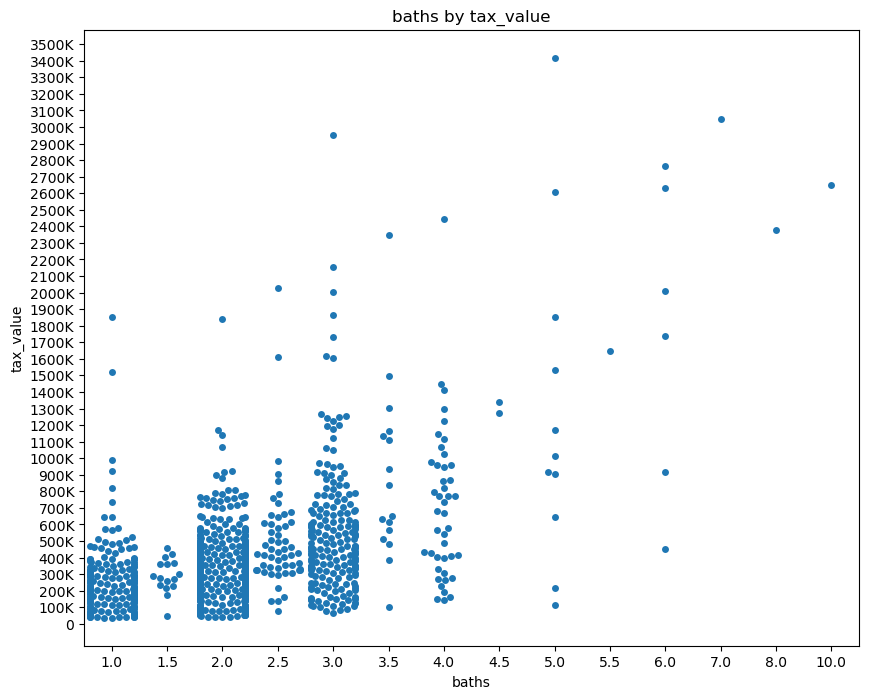

In [72]:
train_sample = zillow_clean.sample(1000)

# Create a swarm plot using Seaborn
plt.figure(figsize=(10, 8))
sns.swarmplot(data=train_sample, x='baths', y='tax_value')

# Customize the y-axis ticks and labels for tax_value
ax = plt.gca()  # Get the current Axes

# Set the y-axis ticks in increments of 100,000
tick_values = range(0, int(train_sample['tax_value'].max()) + 100000, 100000)
ax.set_yticks(tick_values)

# Format the y-axis tick labels to display values in hundreds of thousands
tick_labels = [f'{val/100000:.0f}00K' if val > 0 else '0' for val in tick_values]
ax.set_yticklabels(tick_labels)

plt.title("baths by tax_value")
plt.show()

### Hypothesis

- ${H_0}$: There is no linear correlation between baths and taxvalue
- ${H_a}$:  There is a linear correlation between baths and taxvalue

In [73]:
r, p = spearmanr(train_scaled.baths, train_scaled.tax_value)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between baths and taxvalue.')
else:
    print('We fail to reject the null hypothesis')
    
print(r,p)

We can reject our null hypothesis and suggest that there is a relationship between baths and taxvalue.
0.47510744745161876 0.0


>## <u>Does yearbuilt correlate with Tax Value?</u>

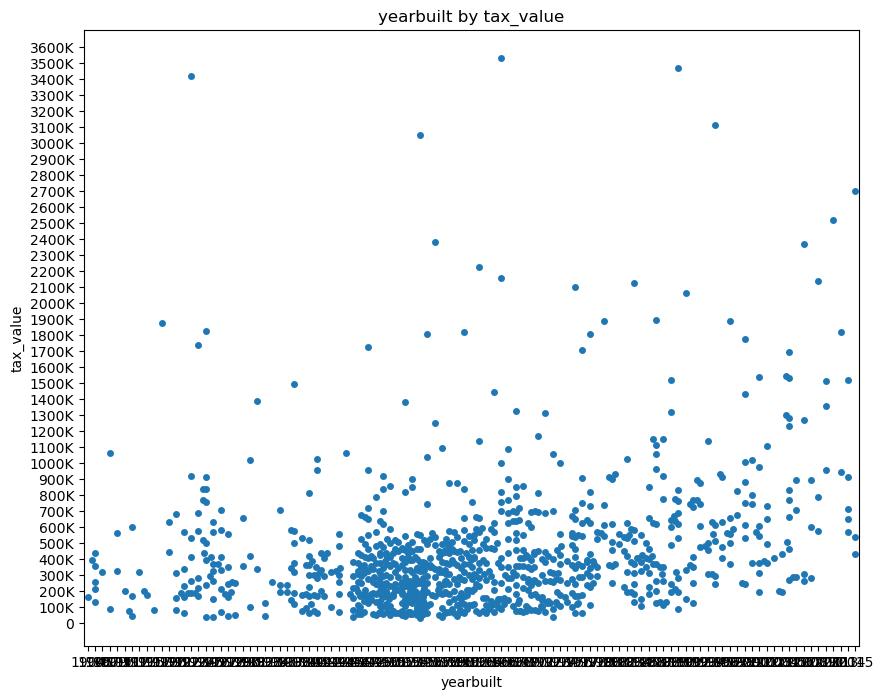

In [74]:
train_sample = zillow_clean.sample(1000)

# Create a swarm plot using Seaborn
plt.figure(figsize=(10, 8))
sns.swarmplot(data=train_sample, x='yearbuilt', y='tax_value')

# Customize the y-axis ticks and labels for tax_value
ax = plt.gca()  # Get the current Axes

# Set the y-axis ticks in increments of 100,000
tick_values = range(0, int(train_sample['tax_value'].max()) + 100000, 100000)
ax.set_yticks(tick_values)

# Format the y-axis tick labels to display values in hundreds of thousands
tick_labels = [f'{val/100000:.0f}00K' if val > 0 else '0' for val in tick_values]
ax.set_yticklabels(tick_labels)

plt.title("yearbuilt by tax_value")
plt.show()

### Hypothesis

- ${H_0}$: There is no linear correlation between yearbuilt and taxvalue
- ${H_a}$:  There is a linear correlation between yearbuilt and taxvalue

In [75]:
r, p = spearmanr(train_scaled.yearbuilt, train_scaled.tax_value)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between yearbuilt and taxvalue.')
else:
    print('We fail to reject the null hypothesis')
    
print(r,p)

We can reject our null hypothesis and suggest that there is a relationship between yearbuilt and taxvalue.
0.286768547325625 0.0


>## <u>Does having a pool correlate with Tax Value?</u>

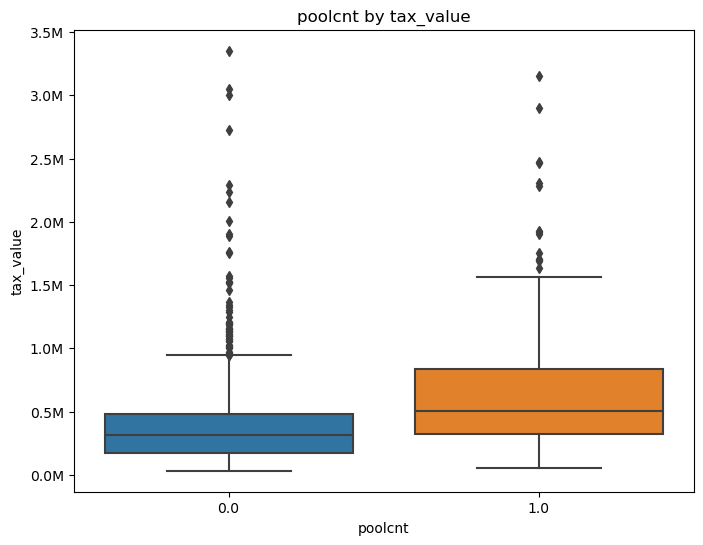

In [76]:
# Sample data (replace this with your actual data)
train_sample = train_scaled.sample(1000)

# Create a boxplot using Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_sample.poolcnt, y=train_sample.tax_value, data=train_sample)

# Customize the y-axis labels to display values in millions
ax = plt.gca()  # Get the current Axes

# Format the y-axis tick labels to display values in millions
tick_labels = [f'{val/1000000:.1f}M' for val in ax.get_yticks()]
ax.set_yticklabels(tick_labels)

plt.title("poolcnt by tax_value")
plt.show()

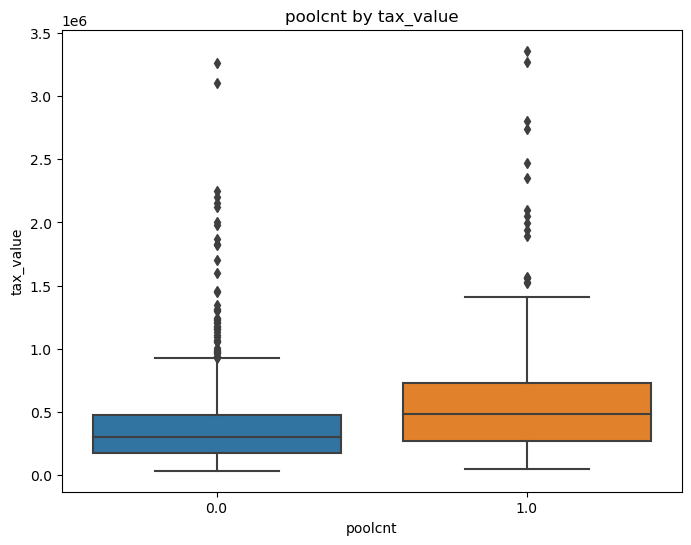

In [77]:
# Plot a boxplot of the continuous variable for each categorical variable
train_sample = train_scaled.sample(1000)
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_sample.poolcnt, y=train_sample.tax_value, data=train_sample)
plt.title(f"poolcnt by tax_value")
plt.show()

### Hypothesis

- ${H_0}$: There is no linear correlation between poolcnt and taxvalue
- ${H_a}$:  There is a linear correlation between poolcnt and taxvalue

In [78]:
r, p = spearmanr(train_scaled.poolcnt, train_scaled.tax_value)

if p < alpha:
    print('We can reject our null hypothesis and suggest that there is a relationship between poolcnt and taxvalue.')
else:
    print('We fail to reject the null hypothesis')
    
print(r,p)

We can reject our null hypothesis and suggest that there is a relationship between poolcnt and taxvalue.
0.23506040285163193 0.0


<Axes: >

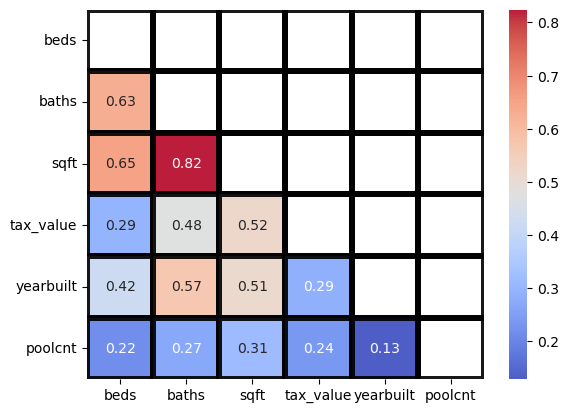

In [79]:
# specify spearman relationships
corrs = train.corr(method='spearman')

kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black',
          'cmap': 'coolwarm',
          'annot': True,
          'mask': np.triu(corrs)}
# function call has no more stuff inline
sns.heatmap(corrs,
            **kwargs)

## Exploration Summary:
All of the features investigated were found to be statistically significant. Because some of these features are closely associated we will use all to model, but may eliminate some alike features to avoid multicolinearity.

##### Potential Features:
	1. sqft
	2. baths
	3. beds
	4. poolcnt
	5. yearbuilt

<hr style="border:2px solid black">

# **Modeling**
Plan --> Acquire --> Prepare --> Explore --> **Model** --> Deliver



In [80]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [81]:
# Create feature sets 
features1 = ['beds','baths', 'poolcnt', 'yearbuilt']
features2 = ['baths', 'sqft', 'poolcnt']
features3 = ['sqft', 'poolcnt']
features4 = ['beds','baths','sqft', 'poolcnt']
features5 = ['beds','baths','sqft', 'poolcnt', 'yearbuilt']

### **Baseline**

In [82]:
baseline = y_train.mean()

#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(x_train))

rmse_train, r2_train = metrics_reg(y_train, baseline_array)
rmse_val, r2_val = metrics_reg(y_train, baseline_array)
rmse_test = np.float64(0)
r2_test = np.float64(0)
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse_train':rmse_train,
        'r2_train':r2_train,
        'rmse_val': rmse_val,
        'r2_val': r2_val,
        'rmse_test': rmse_test,
        'r2_test': r2_test
    }
    
])
metrics_df


,model,rmse_train,r2_train,rmse_val,r2_val,rmse_test,r2_test
0,baseline,404332.375604,0.0,404332.375604,0.0,0.0,0.0


## **Model 1:OLS**
##### SelectKBest

In [83]:
# initialize OLS model
lr1 = LinearRegression()

# create object
rfe = RFE(lr1, n_features_to_select=2)

# fit it
rfe.fit(x_train, y_train)

# use it on train
x_train_rfe = rfe.transform(x_train)

# use it on validate
x_val_rfe = rfe.transform(x_validate)


In [84]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['beds' 'sqft']


##### Fit/Predict

In [85]:
# ols model object
ols = LinearRegression()

#fit the thing
ols.fit(x_train[features5], y_train)

#use it on train
pred_ols = ols.predict(x_train[features5])

# use it on validate
pred_val_ols = ols.predict(x_validate[features5])

##### Evaluate

In [86]:
#train 
rmse_train, r2_train = metrics_reg(y_train, pred_ols)

#validate
rmse_val, r2_val = metrics_reg(y_validate, pred_val_ols)

#add to my metrics df
metrics_df.loc[1] = ['ols', rmse_train, r2_train, rmse_val, r2_val,rmse_test, r2_test]
metrics_df

,model,rmse_train,r2_train,rmse_val,r2_val,rmse_test,r2_test
0,baseline,404332.375604,0.00000,404332.375604,0.000000,0.0,0.0
1,ols,304424.931119,0.43313,310986.072016,0.414654,0.0,0.0


## **Model 2: LassoLars**
##### Fit/Predict

In [87]:
#make it
lars = LassoLars(alpha=4)

#fit it
lars.fit(x_train, y_train)

#use it
pred_lars = lars.predict(x_train)
pred_val_lars = lars.predict(x_validate)

##### Evaluate

In [88]:
# train
rmse_train, r2_train = metrics_reg(y_train, pred_lars)
# validate
rmse_val, r2_val = metrics_reg(y_validate, pred_val_lars)

#add to my metrics df
metrics_df.loc[2] = ['lars', rmse_train, r2_train, rmse_val, r2_val,rmse_test, r2_test]
metrics_df

,model,rmse_train,r2_train,rmse_val,r2_val,rmse_test,r2_test
0,baseline,404332.375604,0.00000,404332.375604,0.000000,0.0,0.0
1,ols,304424.931119,0.43313,310986.072016,0.414654,0.0,0.0
2,lars,304425.013790,0.43313,310990.458108,0.414637,0.0,0.0


## **Model 2: 2nd Degree Polynomial**
##### Fit/Predict

In [89]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform x_train_scaled
x_train_degree2 = pf.fit_transform(x_train)

# transform x_validate_scaled & x_test_scaled
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)

In [90]:
#make it
pr = LinearRegression()

#fit it
pr.fit(x_train_degree2, y_train)

#use it
pred_pr = pr.predict(x_train_degree2)
pred_val_pr = pr.predict(x_validate_degree2)

##### Evaluate

In [91]:
# train
rmse_train, r2_train = metrics_reg(y_train, pred_pr)

# validate
rmse_val, r2_val = metrics_reg(y_validate, pred_val_pr)

#add to my metrics df
metrics_df.loc[3] = ['poly_2', rmse_train, r2_train, rmse_val, r2_val,rmse_test, r2_test]
metrics_df

,model,rmse_train,r2_train,rmse_val,r2_val,rmse_test,r2_test
0,baseline,404332.375604,0.000000,404332.375604,0.000000,0.0,0.0
1,ols,304424.931119,0.433130,310986.072016,0.414654,0.0,0.0
2,lars,304425.013790,0.433130,310990.458108,0.414637,0.0,0.0
3,poly_2,300647.297174,0.447111,306121.231299,0.432824,0.0,0.0


## **Model 3:GLM**
##### Fit/Predict

In [92]:
#make it
glm = TweedieRegressor(power=0, alpha=0)

#fit it
glm.fit(x_train, y_train)

#use it
pred_glm = glm.predict(x_train)
pred_val_glm = glm.predict(x_validate)

In [93]:
# train
rmse_train, r2_train = metrics_reg(y_train, pred_glm)

# validate
rmse_val, r2_val = metrics_reg(y_validate, pred_val_glm)

In [94]:
metrics_df.loc[4] = ['glm',rmse_train,r2_train, rmse_val, r2_val,rmse_test, r2_test]
metrics_df

,model,rmse_train,r2_train,rmse_val,r2_val,rmse_test,r2_test
0,baseline,404332.375604,0.000000,404332.375604,0.000000,0.0,0.0
1,ols,304424.931119,0.433130,310986.072016,0.414654,0.0,0.0
2,lars,304425.013790,0.433130,310990.458108,0.414637,0.0,0.0
3,poly_2,300647.297174,0.447111,306121.231299,0.432824,0.0,0.0
4,glm,304847.249118,0.431556,311482.005917,0.412785,0.0,0.0


## Evaluate Best Model on test data

In [95]:
# train
rmse_train, r2_train = metrics_reg(y_train, pred_pr)

# validate
rmse_val, r2_val = metrics_reg(y_validate, pred_val_pr)

# predict on test
pred_test_pr = pr.predict(x_test_degree2)

# test
rmse_test, r2_test = metrics_reg(y_test,pred_test_pr)

metrics_df.loc[5] = ['poly_2',rmse_train,r2_train, rmse_val, r2_val, rmse_test, r2_test]
metrics_df

,model,rmse_train,r2_train,rmse_val,r2_val,rmse_test,r2_test
0,baseline,404332.375604,0.000000,404332.375604,0.000000,0.000000,0.000000
1,ols,304424.931119,0.433130,310986.072016,0.414654,0.000000,0.000000
2,lars,304425.013790,0.433130,310990.458108,0.414637,0.000000,0.000000
3,poly_2,300647.297174,0.447111,306121.231299,0.432824,0.000000,0.000000
4,glm,304847.249118,0.431556,311482.005917,0.412785,0.000000,0.000000
5,poly_2,300647.297174,0.447111,306121.231299,0.432824,289667.699402,0.465748


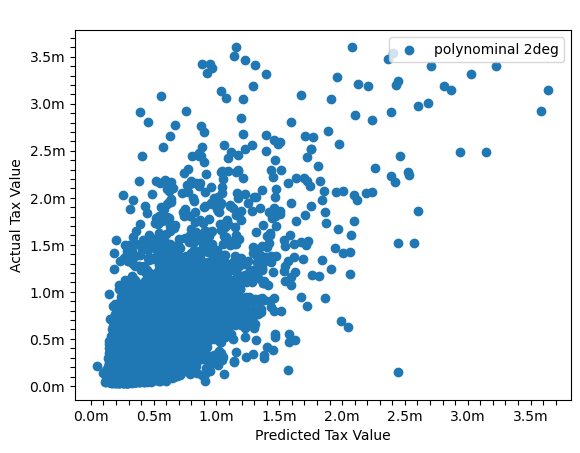

In [98]:

plt.scatter(pred_test_pr, y_test, label='polynominal 2deg')



# Customize the x-axis ticks
x_ticks = range(0, int(max(pred_test_pr)) + 100000, 100000)
x_tick_labels = [f'{val/1000000:.1f}m' if val % 500000 == 0 else '' for val in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

# Customize the y-axis ticks
y_ticks = range(0, int(max(y_test)) + 100000, 100000)
y_tick_labels = [f'{val/1000000:.1f}m' if val % 500000 == 0 else '' for val in y_ticks]
plt.yticks(y_ticks, y_tick_labels)

plt.title(" ")
plt.ylabel("Actual Tax Value")
plt.xlabel("Predicted Tax Value")
plt.legend()

plt.show()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>model</th>
      <th>rmse_train</th>
      <th>r2_train</th>
      <th>rmse_val</th>
      <th>r2_val</th>
      <th>rmse_test</th>
      <th>r2_test</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>baseline</td>
      <td>404332.375604</td>
      <td>0.000000</td>
      <td>404332.375604</td>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>ols</td>
      <td>304424.931119</td>
      <td>0.433130</td>
      <td>310986.072016</td>
      <td>0.414654</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>2</th>
      <td>lars</td>
      <td>304425.013790</td>
      <td>0.433130</td>
      <td>310990.458108</td>
      <td>0.414637</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>3</th>
      <td>poly_2</td>
      <td>300647.297174</td>
      <td>0.447111</td>
      <td>306121.231299</td>
      <td>0.432824</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>4</th>
      <td>glm</td>
      <td>304847.249118</td>
      <td>0.431556</td>
      <td>311482.005917</td>
      <td>0.412785</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>poly_2</td>
      <td>300647.297174</td>
      <td>0.447111</td>
      <td>306121.231299</td>
      <td>0.432824</td>
      <td>289667.699402</td>
      <td>0.465748</td>
    </tr>
  </tbody>
</table>
</div>

<hr style="border:2px solid black">

# **Conclusions**


### <u>Modeling:</u>

>**<u>Model Performance:</u>**
>* Best performing model is our 2nd degree polynomial. It had a rmse on test of $289,667.70 and r2 of 0.47.
>* Strongest features are the number of beds, baths, sqft

### <u>Next Steps:</u>
>* Zillow dataset includes many possible features. Do further feature engineering to better capture subsets of the data:
>    * Distressed properties: tax_delinquency, having more than 2x bedrooms to bathrooms...
>    * High-end properties: Can lot size help predict high-end properties when our features cannot?
>* Spend more time investigating outliers. Eliminating the top 0.5% and bottom 0.5% had the biggest positive impact on the model. Are there erros in the data or are our features missing part of the story? 
>    * Low-end outliers: Are these actually SFR homes? Are there actually structures or just empty lots?
>    * High-end outliers: 